In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import albumentations as A

In [2]:
# Define function to apply weather effects
def apply_weather_effect(image, effect_type="rain"):
    if effect_type == "rain":
        transform = A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=3, p=1)
    elif effect_type == "snow":
        transform = A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)
    return transform(image=image)['image']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset
image_data_dir = "/content/drive/My Drive/CNN/Dataset/train_images"
image_filenames = os.listdir(image_data_dir)
labels_data = pd.read_csv("/content/drive/My Drive/CNN/Dataset/labels.csv")

# Preprocess and separate original and augmented data
original_images = []
augmented_images = []
original_labels = []
augmented_labels = []

for filename in image_filenames:
    image_path = os.path.join(image_data_dir, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image is not None else None
    if image is not None and filename in labels_data['image_filename'].values:
        label = labels_data[labels_data['image_filename'] == filename]['label'].iloc[0]
        original_images.append(image)
        original_labels.append(label)

        # Randomly decide to augment with weather effects
        if np.random.rand() < 0.5:  # 50% chance to augment
            effect_type = np.random.choice(["rain", "snow"])
            aug_image = apply_weather_effect(image, effect_type=effect_type)
            augmented_images.append(aug_image)
            augmented_labels.append(label)

In [5]:
# Convert lists to arrays
X_original = np.array(original_images)
y_original = to_categorical(np.array(original_labels))
X_augmented = np.array(augmented_images)
y_augmented = to_categorical(np.array(augmented_labels))

# Combine original and augmented for validation and testing
X_combined = np.concatenate((X_original, X_augmented))
y_combined = np.concatenate((y_original, y_augmented))

# Split into training, validation, and test sets
X_train_orig, X_temp, y_train_orig, y_temp = train_test_split(X_original, y_original, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, test_size=0.5, random_state=42)  # Split combined for validation and testing

X_train_aug, _, y_train_aug, _ = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)  # Training set for augmented model

In [6]:
from tensorflow.keras.applications import ResNet50

def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [7]:
# Create and train baseline model
baseline_model = create_model(X_train_orig.shape[1:], y_train_orig.shape[1])
baseline_history = baseline_model.fit(X_train_orig, y_train_orig, epochs=40, validation_data=(X_val, y_val))


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/40
21/21 [==============================] - 26s 773ms/step - loss: 11.7827 - accuracy: 0.8612 - val_loss: 11.5977 - val_accuracy: 0.8684
Epoch 2/40
21/21 [==============================] - 11s 545ms/step - loss: 1.3381 - accuracy: 0.9657 - val_loss: 6.2044 - val_accuracy: 0.8743
Epoch 3/40
21/21 [==============================] - 11s 550ms/step - loss: 0.1704 - accuracy: 0.9860 - val_loss: 4.6775 - val_accuracy: 0.9020
Epoch 4/40
21/21 [==============================] - 11s 557ms/step - loss: 0.1544 - accuracy: 0.9906 - val_loss: 6.3476 - val_accuracy: 0.8801
Epoch 5/40
21/21 [==============================] - 12s 564ms/step - loss: 0.1504 - accuracy: 0.9953 - val_loss: 8.2632 - val_accuracy: 0.8743
Epoch 6/40
21/21 [==============================] - 12s 567ms/step - loss: 0.0301 - accuracy: 0.9953 - val_loss: 5.8787 - val_accuracy: 0.8962
Epoch 7/40
21/21 [==============================] - 12s 563ms/step - loss: 

In [8]:
# Create and train augmented model
augmented_model = create_model(X_train_aug.shape[1:], y_train_aug.shape[1])
augmented_history = augmented_model.fit(X_train_aug, y_train_aug, epochs=40, validation_data=(X_val, y_val))


Epoch 1/40
10/10 [==============================] - 17s 2s/step - loss: 13.7892 - accuracy: 0.7880 - val_loss: 5.2756 - val_accuracy: 0.9313
Epoch 2/40
10/10 [==============================] - 9s 923ms/step - loss: 1.6206 - accuracy: 0.9747 - val_loss: 3.5995 - val_accuracy: 0.9576
Epoch 3/40
10/10 [==============================] - 9s 931ms/step - loss: 0.4936 - accuracy: 0.9905 - val_loss: 3.6346 - val_accuracy: 0.9591
Epoch 4/40
10/10 [==============================] - 9s 929ms/step - loss: 0.0133 - accuracy: 0.9968 - val_loss: 3.9449 - val_accuracy: 0.9591
Epoch 5/40
10/10 [==============================] - 9s 925ms/step - loss: 1.1317e-09 - accuracy: 1.0000 - val_loss: 4.0440 - val_accuracy: 0.9605
Epoch 6/40
10/10 [==============================] - 9s 922ms/step - loss: 0.0282 - accuracy: 0.9968 - val_loss: 4.1776 - val_accuracy: 0.9576
Epoch 7/40
10/10 [==============================] - 9s 920ms/step - loss: 1.1317e-09 - accuracy: 1.0000 - val_loss: 5.1203 - val_accuracy: 0.9561

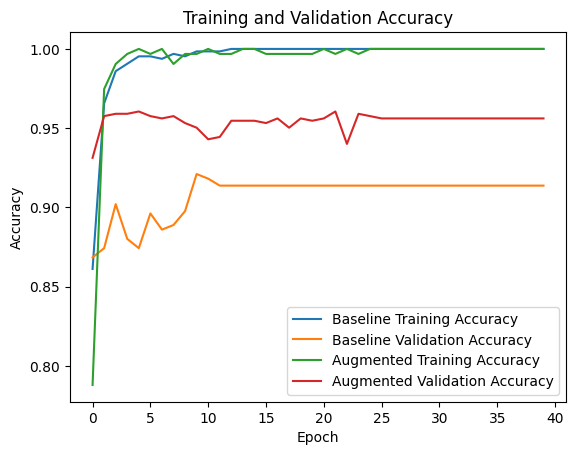

In [9]:
import matplotlib.pyplot as plt
plt.plot(baseline_history.history['accuracy'], label='Baseline Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Validation Accuracy')
plt.plot(augmented_history.history['accuracy'], label='Augmented Training Accuracy')
plt.plot(augmented_history.history['val_accuracy'], label='Augmented Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [10]:
# Evaluate both models on the test set
baseline_score = baseline_model.evaluate(X_test, y_test, verbose=0)
augmented_score = augmented_model.evaluate(X_test, y_test, verbose=0)
print("Baseline Model - Test loss:", baseline_score[0], "Test accuracy:", baseline_score[1])
print("Augmented Model - Test loss:", augmented_score[0], "Test accuracy:", augmented_score[1])

Baseline Model - Test loss: 6.207990646362305 Test accuracy: 0.9137426614761353
Augmented Model - Test loss: 3.3475606441497803 Test accuracy: 0.9634503126144409


In [13]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [17]:
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from keras_tuner import Hyperband
from keras_tuner import BayesianOptimization
from tensorflow.keras import Sequential
from kerastuner.tuners import GridSearch

def create_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))  # Adjusted for your images
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'])),
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(2, activation='softmax')  # Assuming you have 2 classes
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


<ipython-input-17-9d4f918ce15f>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import GridSearch


In [20]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Create a HyperParameters object and specify the hyperparameters
hp = HyperParameters()
hp.Choice('units', [32, 64, 128])
hp.Choice('dropout', [0.0, 0.1, 0.2])
hp.Choice('learning_rate', [1e-4, 1e-3])

# Define the RandomSearch tuner with the HyperParameters object
tuner = RandomSearch(
    create_model,
    max_trials=10,  # Limit the number of trials to 10
    hyperparameters=hp,
    objective='val_accuracy',
    directory='model_tuning',
    project_name='WeedDetection_random'
)

# Start tuning with the training data
tuner.search(X_train_aug, y_train_aug, epochs=7, validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters are:
- Units: {best_hps.get('units')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# You can also retrain the model with the best hyperparameters or analyze them further
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 01m 16s]
val_accuracy: 0.9634503126144409

Best val_accuracy So Far: 0.9634503126144409
Total elapsed time: 00h 12m 06s

The best hyperparameters are:
- Units: 128
- Dropout: 0.2
- Learning Rate: 0.001



In [37]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(best_trial.trial_id)

09


In [21]:
GridSearch_score=best_model.evaluate(X_test,y_test,verbose=0)
print("Grid Search Model - test loss:", GridSearch_score[0], "test accuracy:", GridSearch_score[1])

Grid Search Model - test loss: 5.655336380004883 test accuracy: 0.969298243522644


In [24]:
# percentage change in test loss
change_loss=((GridSearch_score[0]-augmented_score[0])/augmented_score[0])*100
print(f"Percentage change in test loss: {change_loss:.2f}%")

# percentage change in test accuracy
change_acc=((GridSearch_score[1]-augmented_score[1])/augmented_score[1])*100
print(f"Percentage change in test accuracy: {change_acc:.2f}%")



Percentage change in test loss: 68.94%
Percentage change in test accuracy: 0.61%


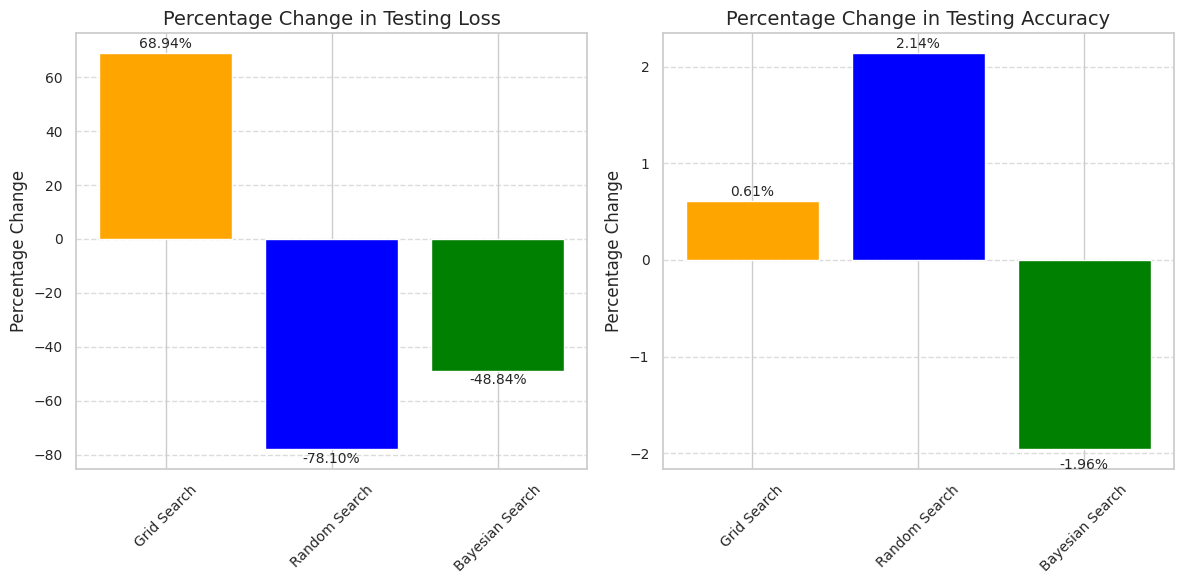

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Method names
methods = ['Grid Search', 'Random Search', 'Bayesian Search']

# Percentage change in testing loss
loss_change = [68.94, -78.10, -48.84]

# Percentage change in testing accuracy
accuracy_change = [0.61, 2.14, -1.96]

# Setting a seaborn style
sns.set(style="whitegrid")

# Define colors
colors = ['orange', 'blue', 'green']

# Plotting
plt.figure(figsize=(12, 6))

# Bar plot for loss change
plt.subplot(1, 2, 1)
plt.bar(methods, loss_change, color=colors)
plt.title('Percentage Change in Testing Loss', fontsize=14)
plt.ylabel('Percentage Change', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations for loss change
for i, value in enumerate(loss_change):
    plt.text(i, value + (2 if value > 0 else -5), f"{value:.2f}%", ha='center', fontsize=10)

# Bar plot for accuracy change
plt.subplot(1, 2, 2)
plt.bar(methods, accuracy_change, color=colors)
plt.title('Percentage Change in Testing Accuracy', fontsize=14)
plt.ylabel('Percentage Change', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations for accuracy change
for i, value in enumerate(accuracy_change):
    plt.text(i, value + (0.05 if value > 0 else -0.2), f"{value:.2f}%", ha='center', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()
